Cell 0: Fix protobuf + reduce TF logging BEFORE importing TensorFlow

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

!pip install --no-cache-dir "protobuf>=3.20.0,<3.21.0"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print("Cell 0 done. If you changed protobuf, restart the kernel and run from Cell 1.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

Cell 1: Safe TensorFlow import & GPU setup

In [2]:
import tensorflow as tf
print("TF Version:", tf.__version__)

# Set GPU memory growth if GPUs present
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass
print("GPUs:", gpus)

2025-11-23 16:21:03.004378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763914863.197571      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763914863.251686      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF Version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Cell 2: Standard imports

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import re
import pickle
import json
import shutil

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("Cell 2 loaded libs")

Cell 2 loaded libs


Cell 3: Paths and dataset checks — adjust if needed

In [4]:
DSV_CSV = Path("/kaggle/input/cvpr-mini-project-dsv-dataset/artifacts/dsv_features/all_dsv_features.csv")
IMG_ROOT = Path("/kaggle/input/2-preprocessing/artifacts/preprocessed_fast/cnn")

assert DSV_CSV.exists(), f"DSV CSV not found: {DSV_CSV}"
print("DSV CSV found:", DSV_CSV.exists())
print("IMG root exists:", IMG_ROOT.exists())

DSV CSV found: True
IMG root exists: True


Cell 4: Load CSV and basic sanity

In [5]:
full_df = pd.read_csv(str(DSV_CSV))
print("Loaded CSV columns:", full_df.columns.tolist())
print("Total rows:", len(full_df))
print(full_df[['image','source','split']].head(5))

denom_classes = sorted(full_df['source'].unique())
print('Denomination classes found:', denom_classes)

train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
val_df = full_df[full_df['split'] == 'validation'].reset_index(drop=True)
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)

print('Rows train/val/test:', len(train_df), len(val_df), len(test_df))

Loaded CSV columns: ['image', 'height', 'width', 'fft_low', 'fft_mid', 'fft_high', 'sobel_mean', 'canny_ratio', 'orb_kp', 'akaze_kp', 'entropy', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7', 'lbp_8', 'lbp_9', 'lbp_10', 'lbp_11', 'lbp_12', 'lbp_13', 'lbp_14', 'lbp_15', 'glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation', 'patch_emb_mean_mean', 'patch_emb_mean_std', 'patch_emb_std_mean', 'patch_emb_std_std', 'patch_count', 'source', 'split']
Total rows: 13224
                                               image           source  split
0  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10  train
1  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10  train
2  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10  train
3  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10  train
4  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10  train
Denominat

Cell 5: Ensure image paths exist and fix minor issues

In [6]:
def check_paths(df, n=10):
    sample = df['image'].iloc[:n]
    ok = [Path(p).exists() for p in sample]
    return all(ok), ok[:n]

print('Train sample paths ok?:', check_paths(train_df, n=5))
print('Val sample paths ok?:', check_paths(val_df, n=5))
print('Test sample paths ok?:', check_paths(test_df, n=5))

Train sample paths ok?: (True, [True, True, True, True, True])
Val sample paths ok?: (True, [True, True, True, True, True])
Test sample paths ok?: (True, [True, True, True, True, True])


Cell 6: Build denomination & auth columns from "source"

In [7]:
train_df['denomination'] = train_df['source']
val_df['denomination'] = val_df['source']
test_df['denomination'] = test_df['source']

train_df['auth'] = (train_df['source'] != 'denomination_fake').astype(int)
val_df['auth'] = (val_df['source'] != 'denomination_fake').astype(int)
test_df['auth'] = (test_df['source'] != 'denomination_fake').astype(int)

print('Auth distribution train:', train_df['auth'].value_counts().to_dict())

denom_encoder = LabelEncoder()
denom_encoder.fit(train_df['denomination'].values)
print('Denom classes (encoder):', denom_encoder.classes_)

train_df['denom_label'] = denom_encoder.transform(train_df['denomination'])
val_df['denom_label'] = denom_encoder.transform(val_df['denomination'])
test_df['denom_label'] = denom_encoder.transform(test_df['denomination'])

with open('denom_encoder.pkl','wb') as f:
    pickle.dump(denom_encoder, f)

Auth distribution train: {1: 8926, 0: 327}
Denom classes (encoder): ['denomination_10' 'denomination_100' 'denomination_20' 'denomination_200'
 'denomination_2000' 'denomination_50' 'denomination_500'
 'denomination_fake']


Cell 7: Sanity prints

In [8]:
print(train_df[['image','denomination','denom_label','auth']].head(3))

train_df['auth'] = train_df['auth'].astype(int)
val_df['auth'] = val_df['auth'].astype(int)
test_df['auth'] = test_df['auth'].astype(int)

                                               image     denomination  \
0  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10   
1  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10   
2  /kaggle/input/2-preprocessing/artifacts/prepro...  denomination_10   

   denom_label  auth  
0            0     1  
1            0     1  
2            0     1  


Cell 8: tf.data pipeline

In [9]:
IMG_SIZE = (224,224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_DENOM_CLASSES = len(denom_encoder.classes_)

def parse_image(filename, denom_int, auth):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    denom_onehot = tf.one_hot(denom_int, depth=NUM_DENOM_CLASSES)
    return img, {"denom": denom_onehot, "auth": tf.cast(auth, tf.float32)}

def df_to_ds(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df['image'].values, df['denom_label'].values, df['auth'].values))
    if shuffle:
        ds = ds.shuffle(buffer_size=4096)
    ds = ds.map(parse_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_ds(train_df, shuffle=True)
val_ds = df_to_ds(val_df, shuffle=False)
test_ds = df_to_ds(test_df, shuffle=False)

batch = next(iter(train_ds))
imgs, labels = batch
print('imgs shape:', imgs.shape)
print('denom label shape:', labels['denom'].shape)
print('auth label shape:', labels['auth'].shape)

I0000 00:00:1763914880.009575      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763914880.010269      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


imgs shape: (32, 224, 224, 3)
denom label shape: (32, 8)
auth label shape: (32,)


Cell 9: Build model (MobileNetV2)

In [10]:
base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

for layer in base.layers:
    layer.trainable = True

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

denom_out = Dense(NUM_DENOM_CLASSES, activation='softmax', name='denom')(x)
auth_out = Dense(1, activation='sigmoid', name='auth')(x)

model = Model(inputs=base.input, outputs=[denom_out, auth_out])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,233 (9.87 MB)

 Trainable params: 2,554,121 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

Cell 10: Weighted BCE loss + compile

In [11]:
auth_vals = train_df['auth'].values
auth_cw = class_weight.compute_class_weight('balanced', classes=np.unique(auth_vals), y=auth_vals)
pos_weight = float(auth_cw[0] / auth_cw[1]) if len(auth_cw)==2 else 1.0
print('pos_weight:', pos_weight)

def weighted_bce_loss(pos_weight):
    def loss(y_true, y_pred):
        w = y_true * pos_weight + (1.0 - y_true)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return w * bce
    return loss

losses = {'denom': 'categorical_crossentropy', 'auth': weighted_bce_loss(pos_weight)}

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=losses, metrics={'denom':'accuracy','auth':'accuracy'})
print('Model compiled')

pos_weight: 27.296636085626908
Model compiled


Cell 11: Training

In [12]:
ckpt = ModelCheckpoint('dual_head_mobilenetv2.h5', save_best_only=True, monitor='val_loss', verbose=1)
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

history = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[ckpt, early, reduce])
print('Training complete')

Epoch 1/40


I0000 00:00:1763914920.193137      67 service.cc:148] XLA service 0x7f3740001a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763914920.194110      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763914920.194131      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763914923.496589      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763914942.717278      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auth_accuracy: 0.9803 - auth_loss: 1.4073 - denom_accuracy: 0.4284 - denom_loss: 1.5743 - loss: 2.9816
Epoch 1: val_loss improved from inf to 8.23890, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 121s 214ms/step - auth_accuracy: 0.9804 - auth_loss: 1.4060 - denom_accuracy: 0.4289 - denom_loss: 1.5730 - loss: 2.9791 - val_auth_accuracy: 0.9107 - val_auth_loss: 7.0922 - val_denom_accuracy: 0.5719 - val_denom_loss: 1.1343 - val_loss: 8.2389 - learning_rate: 1.0000e-04
Epoch 2/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - auth_accuracy: 0.9991 - auth_loss: 0.0849 - denom_accuracy: 0.8011 - denom_loss: 0.5620 - loss: 0.6468
Epoch 2: val_loss improved from 8.23890 to 7.87732, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 36s 125ms/step - auth_accuracy: 0.9991 - auth_loss: 0.0851 - denom_accuracy: 0.8015 - denom_loss: 0.5610 - loss: 0.6460 - val_auth_accuracy: 0.9243 - val_auth_loss: 7.0986 - val_denom_accuracy: 0.7203 - val_denom_loss: 0.7668 - val_loss: 7.8773 - learning_rate: 1.0000e-04
Epoch 3/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - auth_accuracy: 0.9996 - auth_loss: 0.0473 - denom_accuracy: 0.8893 - denom_loss: 0.3232 - loss: 0.3705
Epoch 3: val_loss improved from 7.87732 to 3.43775, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - auth_accuracy: 0.9996 - auth_loss: 0.0473 - denom_accuracy: 0.8895 - denom_loss: 0.3225 - loss: 0.3698 - val_auth_accuracy: 0.9631 - val_auth_loss: 2.9786 - val_denom_accuracy: 0.8354 - val_denom_loss: 0.4539 - val_loss: 3.4378 - learning_rate: 1.0000e-04
Epoch 4/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 0.9994 - auth_loss: 0.0389 - denom_accuracy: 0.9198 - denom_loss: 0.2420 - loss: 0.2809
Epoch 4: val_loss improved from 3.43775 to 2.95507, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 0.9994 - auth_loss: 0.0392 - denom_accuracy: 0.9200 - denom_loss: 0.2414 - loss: 0.2806 - val_auth_accuracy: 0.9738 - val_auth_loss: 2.3554 - val_denom_accuracy: 0.7940 - val_denom_loss: 0.5952 - val_loss: 2.9551 - learning_rate: 1.0000e-04
Epoch 5/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - auth_accuracy: 0.9994 - auth_loss: 0.0279 - denom_accuracy: 0.9388 - denom_loss: 0.1763 - loss: 0.2042
Epoch 5: val_loss did not improve from 2.95507
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - auth_accuracy: 0.9994 - auth_loss: 0.0280 - denom_accuracy: 0.9390 - denom_loss: 0.1760 - loss: 0.2040 - val_auth_accuracy: 0.9278 - val_auth_loss: 8.6709 - val_denom_accuracy: 0.8521 - val_denom_loss: 0.5990 - val_loss: 9.2839 - learning_rate: 1.0000e-04
Epoch 6/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 0.9994 - auth_loss: 0.0583 - denom_accuracy: 0.9443 - denom_loss: 0.1686 - loss: 0.2268
Epoch 6: val_loss did not impro

290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 0.9999 - auth_loss: 0.0174 - denom_accuracy: 0.9499 - denom_loss: 0.1545 - loss: 0.1719 - val_auth_accuracy: 0.9950 - val_auth_loss: 0.3365 - val_denom_accuracy: 0.9551 - val_denom_loss: 0.1308 - val_loss: 0.4679 - learning_rate: 1.0000e-04
Epoch 8/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0038 - denom_accuracy: 0.9619 - denom_loss: 0.1111 - loss: 0.1149
Epoch 8: val_loss improved from 0.46794 to 0.23102, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0039 - denom_accuracy: 0.9621 - denom_loss: 0.1107 - loss: 0.1146 - val_auth_accuracy: 0.9980 - val_auth_loss: 0.1549 - val_denom_accuracy: 0.9727 - val_denom_loss: 0.0757 - val_loss: 0.2310 - learning_rate: 1.0000e-04
Epoch 9/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 0.9995 - auth_loss: 0.0428 - denom_accuracy: 0.9687 - denom_loss: 0.0898 - loss: 0.1327
Epoch 9: val_loss improved from 0.23102 to 0.21227, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - auth_accuracy: 0.9995 - auth_loss: 0.0431 - denom_accuracy: 0.9688 - denom_loss: 0.0896 - loss: 0.1327 - val_auth_accuracy: 0.9980 - val_auth_loss: 0.0168 - val_denom_accuracy: 0.9414 - val_denom_loss: 0.1954 - val_loss: 0.2123 - learning_rate: 1.0000e-04
Epoch 10/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 0.9999 - auth_loss: 0.0096 - denom_accuracy: 0.9660 - denom_loss: 0.1085 - loss: 0.1181
Epoch 10: val_loss improved from 0.21227 to 0.12735, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 0.9999 - auth_loss: 0.0098 - denom_accuracy: 0.9661 - denom_loss: 0.1081 - loss: 0.1179 - val_auth_accuracy: 0.9995 - val_auth_loss: 0.0426 - val_denom_accuracy: 0.9738 - val_denom_loss: 0.0846 - val_loss: 0.1273 - learning_rate: 1.0000e-04
Epoch 11/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 0.9999 - auth_loss: 0.0108 - denom_accuracy: 0.9747 - denom_loss: 0.0696 - loss: 0.0804
Epoch 11: val_loss improved from 0.12735 to 0.05491, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 0.9999 - auth_loss: 0.0108 - denom_accuracy: 0.9748 - denom_loss: 0.0694 - loss: 0.0802 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0073 - val_denom_accuracy: 0.9854 - val_denom_loss: 0.0476 - val_loss: 0.0549 - learning_rate: 1.0000e-04
Epoch 12/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0027 - denom_accuracy: 0.9767 - denom_loss: 0.0680 - loss: 0.0707
Epoch 12: val_loss did not improve from 0.05491
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0027 - denom_accuracy: 0.9768 - denom_loss: 0.0678 - loss: 0.0705 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0019 - val_denom_accuracy: 0.9813 - val_denom_loss: 0.0557 - val_loss: 0.0577 - learning_rate: 1.0000e-04
Epoch 13/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0010 - denom_accuracy: 0.9824 - denom_loss: 0.0521 - loss: 0.0531
Epoch 13: val_loss improved 

290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0010 - denom_accuracy: 0.9824 - denom_loss: 0.0520 - loss: 0.0530 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0021 - val_denom_accuracy: 0.9849 - val_denom_loss: 0.0514 - val_loss: 0.0536 - learning_rate: 1.0000e-04
Epoch 14/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0017 - denom_accuracy: 0.9863 - denom_loss: 0.0423 - loss: 0.0440
Epoch 14: val_loss did not improve from 0.05363
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0017 - denom_accuracy: 0.9863 - denom_loss: 0.0422 - loss: 0.0439 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0011 - val_denom_accuracy: 0.9823 - val_denom_loss: 0.0610 - val_loss: 0.0623 - learning_rate: 1.0000e-04
Epoch 15/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 6.1899e-04 - denom_accuracy: 0.9881 - denom_loss: 0.0382 - loss: 0.0389
Epoch 15: val_loss did n

290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - auth_accuracy: 1.0000 - auth_loss: 5.0419e-04 - denom_accuracy: 0.9889 - denom_loss: 0.0331 - loss: 0.0336 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0014 - val_denom_accuracy: 0.9869 - val_denom_loss: 0.0475 - val_loss: 0.0490 - learning_rate: 3.0000e-05
Epoch 18/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 4.1991e-04 - denom_accuracy: 0.9926 - denom_loss: 0.0207 - loss: 0.0211
Epoch 18: val_loss improved from 0.04898 to 0.04362, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 1.0000 - auth_loss: 4.2200e-04 - denom_accuracy: 0.9926 - denom_loss: 0.0206 - loss: 0.0211 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0014 - val_denom_accuracy: 0.9859 - val_denom_loss: 0.0422 - val_loss: 0.0436 - learning_rate: 3.0000e-05
Epoch 19/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 3.6074e-04 - denom_accuracy: 0.9937 - denom_loss: 0.0210 - loss: 0.0214
Epoch 19: val_loss improved from 0.04362 to 0.04103, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - auth_accuracy: 1.0000 - auth_loss: 3.6034e-04 - denom_accuracy: 0.9938 - denom_loss: 0.0210 - loss: 0.0213 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0013 - val_denom_accuracy: 0.9874 - val_denom_loss: 0.0396 - val_loss: 0.0410 - learning_rate: 3.0000e-05
Epoch 20/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 3.7710e-04 - denom_accuracy: 0.9965 - denom_loss: 0.0136 - loss: 0.0140
Epoch 20: val_loss improved from 0.04103 to 0.04092, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - auth_accuracy: 1.0000 - auth_loss: 3.7740e-04 - denom_accuracy: 0.9965 - denom_loss: 0.0136 - loss: 0.0140 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0011 - val_denom_accuracy: 0.9884 - val_denom_loss: 0.0398 - val_loss: 0.0409 - learning_rate: 3.0000e-05
Epoch 21/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - auth_accuracy: 1.0000 - auth_loss: 3.1537e-04 - denom_accuracy: 0.9952 - denom_loss: 0.0128 - loss: 0.0131
Epoch 21: val_loss did not improve from 0.04092
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - auth_accuracy: 1.0000 - auth_loss: 3.1597e-04 - denom_accuracy: 0.9952 - denom_loss: 0.0128 - loss: 0.0131 - val_auth_accuracy: 1.0000 - val_auth_loss: 6.5685e-04 - val_denom_accuracy: 0.9879 - val_denom_loss: 0.0425 - val_loss: 0.0432 - learning_rate: 3.0000e-05
Epoch 22/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - auth_accuracy: 1.0000 - auth_loss: 2.2693e-04 - denom_accuracy: 0.9959 - denom_loss: 0.0127 - loss: 0.0129
Epoch 22

290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - auth_accuracy: 1.0000 - auth_loss: 2.2710e-04 - denom_accuracy: 0.9975 - denom_loss: 0.0090 - loss: 0.0092 - val_auth_accuracy: 1.0000 - val_auth_loss: 0.0010 - val_denom_accuracy: 0.9884 - val_denom_loss: 0.0395 - val_loss: 0.0406 - learning_rate: 9.0000e-06
Epoch 26/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 2.5895e-04 - denom_accuracy: 0.9959 - denom_loss: 0.0111 - loss: 0.0114
Epoch 26: val_loss did not improve from 0.04058
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - auth_accuracy: 1.0000 - auth_loss: 2.5841e-04 - denom_accuracy: 0.9959 - denom_loss: 0.0111 - loss: 0.0113 - val_auth_accuracy: 1.0000 - val_auth_loss: 8.3206e-04 - val_denom_accuracy: 0.9884 - val_denom_loss: 0.0408 - val_loss: 0.0417 - learning_rate: 9.0000e-06
Epoch 27/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 0.0012 - denom_accuracy: 0.9990 - denom_loss: 0.0045 - loss: 0.0057
Epoch 27: va

290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - auth_accuracy: 1.0000 - auth_loss: 1.9814e-04 - denom_accuracy: 0.9985 - denom_loss: 0.0055 - loss: 0.0057 - val_auth_accuracy: 1.0000 - val_auth_loss: 6.8642e-04 - val_denom_accuracy: 0.9904 - val_denom_loss: 0.0392 - val_loss: 0.0400 - learning_rate: 9.0000e-06
Epoch 29/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 1.8826e-04 - denom_accuracy: 0.9964 - denom_loss: 0.0127 - loss: 0.0129
Epoch 29: val_loss improved from 0.03997 to 0.03869, saving model to dual_head_mobilenetv2.h5


290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - auth_accuracy: 1.0000 - auth_loss: 1.8861e-04 - denom_accuracy: 0.9964 - denom_loss: 0.0127 - loss: 0.0128 - val_auth_accuracy: 1.0000 - val_auth_loss: 6.8318e-04 - val_denom_accuracy: 0.9894 - val_denom_loss: 0.0379 - val_loss: 0.0387 - learning_rate: 9.0000e-06
Epoch 30/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 1.3091e-04 - denom_accuracy: 0.9976 - denom_loss: 0.0057 - loss: 0.0058
Epoch 30: val_loss did not improve from 0.03869
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - auth_accuracy: 1.0000 - auth_loss: 1.3138e-04 - denom_accuracy: 0.9976 - denom_loss: 0.0057 - loss: 0.0058 - val_auth_accuracy: 1.0000 - val_auth_loss: 5.9330e-04 - val_denom_accuracy: 0.9899 - val_denom_loss: 0.0381 - val_loss: 0.0388 - learning_rate: 9.0000e-06
Epoch 31/40
289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auth_accuracy: 1.0000 - auth_loss: 1.6622e-04 - denom_accuracy: 0.9969 - denom_loss: 0.0082 - loss: 0.0084
Epoc

Cell 12: Generate predictions on test set

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true_d = []
y_true_a = []
y_pred_d = []
y_pred_a = []
y_pred_a_prob = []

for imgs, labels in test_ds:
    denom_y = labels['denom']
    auth_y = labels['auth']
    preds_d, preds_a = model.predict(imgs, verbose=0)

    y_true_d.extend(np.argmax(denom_y.numpy(), axis=1).tolist())
    y_true_a.extend(auth_y.numpy().astype(int).tolist())

    y_pred_d.extend(np.argmax(preds_d, axis=1).tolist())
    probs = preds_a.squeeze()
    y_pred_a.extend((probs >= 0.5).astype(int).tolist())
    y_pred_a_prob.extend(probs.tolist())

print('Predictions generated')

Predictions generated


Cell 13: Print comprehensive results

In [14]:
print('\n' + '='*70)
print('TEST SET EVALUATION RESULTS')
print('='*70)

denom_acc = accuracy_score(y_true_d, y_pred_d)
auth_acc = accuracy_score(y_true_a, y_pred_a)

print(f'\nOVERALL ACCURACY:')
print(f'  Denomination Classification: {denom_acc:.4f} ({denom_acc*100:.2f}%)')
print(f'  Authenticity Detection:      {auth_acc:.4f} ({auth_acc*100:.2f}%)')

print('\n' + '-'*70)
print('DENOMINATION CLASSIFICATION REPORT:')
print('-'*70)
print(classification_report(y_true_d, y_pred_d, target_names=denom_encoder.classes_, digits=4))

print('\n' + '-'*70)
print('AUTHENTICITY CLASSIFICATION REPORT:')
print('-'*70)
print(classification_report(y_true_a, y_pred_a, target_names=['Fake', 'Genuine'], digits=4))
print('='*70 + '\n')


TEST SET EVALUATION RESULTS

OVERALL ACCURACY:
  Denomination Classification: 0.9910 (99.10%)
  Authenticity Detection:      1.0000 (100.00%)

----------------------------------------------------------------------
DENOMINATION CLASSIFICATION REPORT:
----------------------------------------------------------------------
                   precision    recall  f1-score   support

  denomination_10     0.9864    0.9775    0.9819       222
 denomination_100     0.9968    0.9813    0.9890       321
  denomination_20     0.9962    0.9962    0.9962       266
 denomination_200     1.0000    0.9963    0.9982       272
denomination_2000     0.9962    0.9962    0.9962       262
  denomination_50     0.9805    0.9844    0.9825       256
 denomination_500     0.9787    1.0000    0.9892       321
denomination_fake     1.0000    1.0000    1.0000        70

         accuracy                         0.9910      1990
        macro avg     0.9919    0.9915    0.9916      1990
     weighted avg     0.991

Cell 14: Save predictions CSV

In [15]:
pd.DataFrame({
    'image': test_df['image'].values,
    'true_denom': denom_encoder.inverse_transform(y_true_d),
    'pred_denom': denom_encoder.inverse_transform(y_pred_d),
    'true_auth': y_true_a,
    'pred_auth': y_pred_a,
    'auth_prob': y_pred_a_prob
}).to_csv('test_predictions.csv', index=False)
print('✓ Predictions saved to test_predictions.csv')

✓ Predictions saved to test_predictions.csv


Cell 15: Enhanced confusion matrices

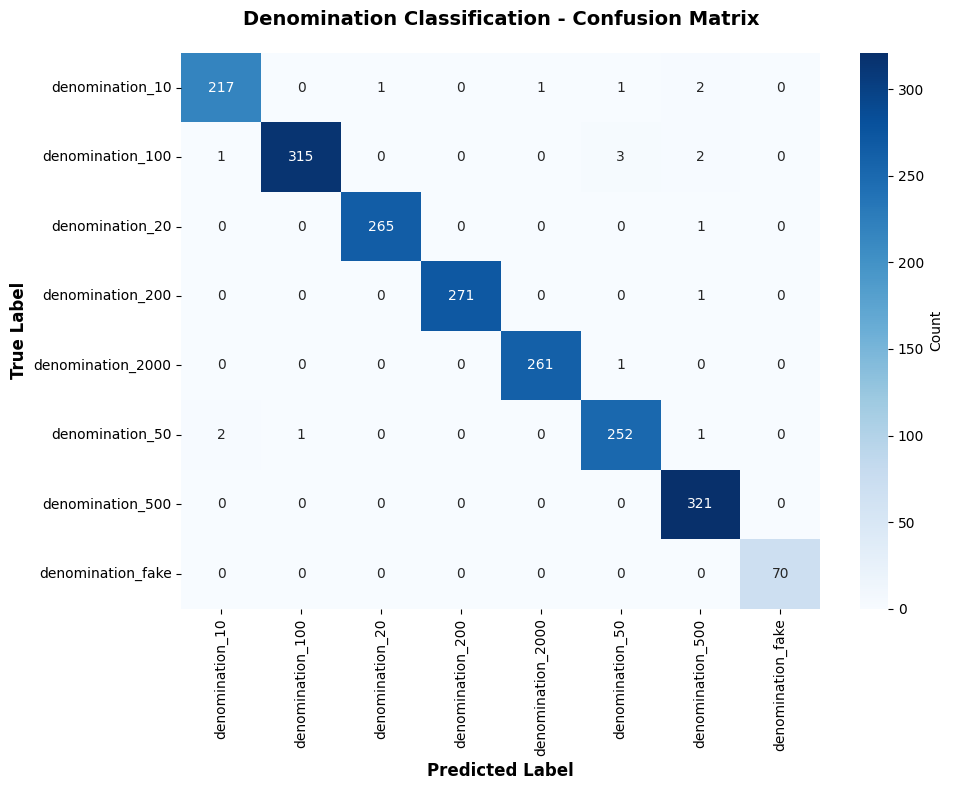

✓ Saved confusion_denom.png


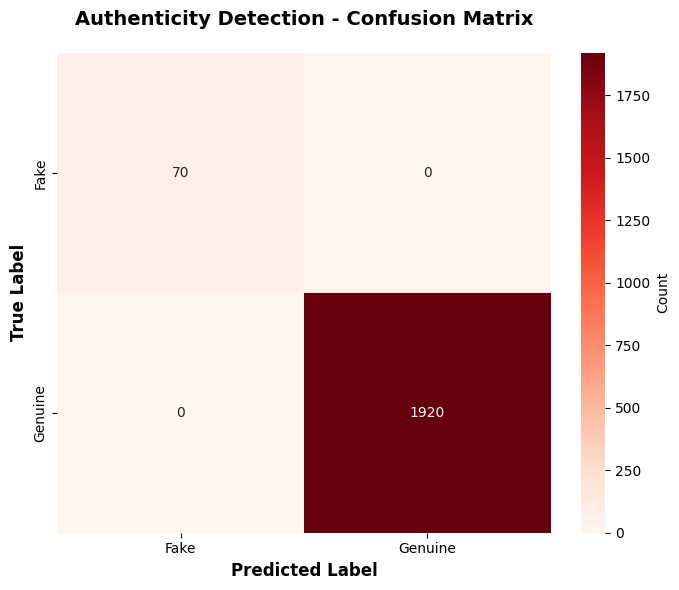

✓ Saved confusion_auth.png


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Denomination confusion matrix with better styling
cm_denom = confusion_matrix(y_true_d, y_pred_d)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_denom, annot=True, fmt='d', 
            xticklabels=denom_encoder.classes_, 
            yticklabels=denom_encoder.classes_, 
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Denomination Classification - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('confusion_denom.png', dpi=200, bbox_inches='tight')
plt.show()
print('✓ Saved confusion_denom.png')

# Authenticity confusion matrix
cm_auth = confusion_matrix(y_true_a, y_pred_a)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_auth, annot=True, fmt='d', 
            xticklabels=['Fake', 'Genuine'], 
            yticklabels=['Fake', 'Genuine'], 
            cmap='Reds', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Authenticity Detection - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('confusion_auth.png', dpi=200, bbox_inches='tight')
plt.show()
print('✓ Saved confusion_auth.png')

Cell 16: ROC and Precision-Recall curves

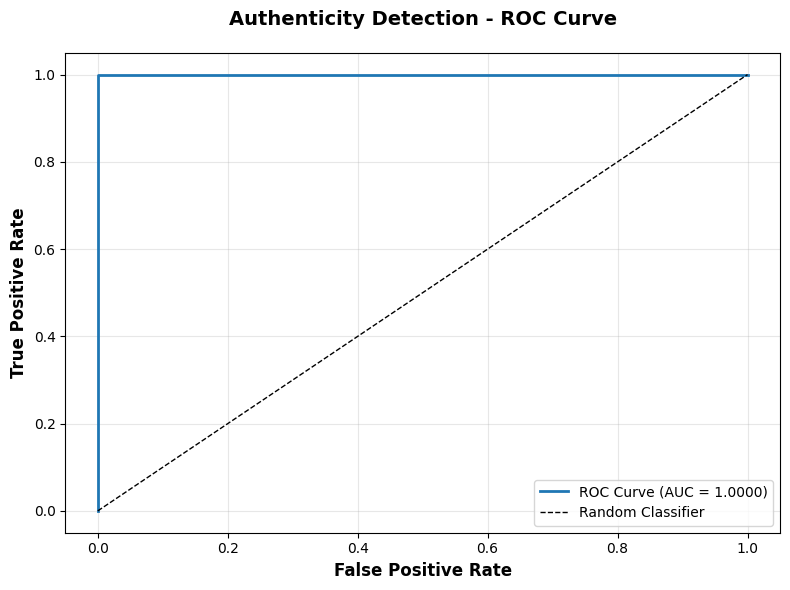

✓ Saved roc_auth.png (AUC: 1.0000)


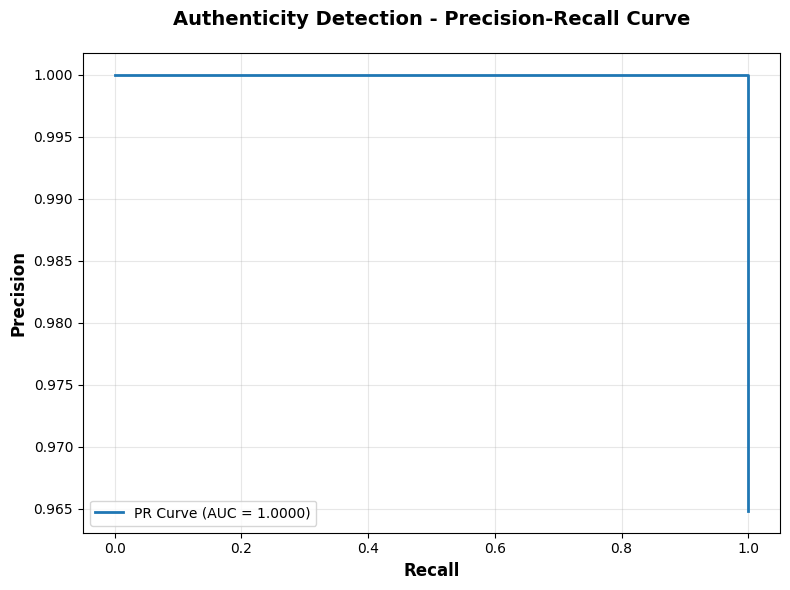

✓ Saved pr_auth.png (AUC: 1.0000)


In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_a, y_pred_a_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Authenticity Detection - ROC Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_auth.png', dpi=200, bbox_inches='tight')
plt.show()
print(f'✓ Saved roc_auth.png (AUC: {roc_auc:.4f})')

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_a, y_pred_a_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Authenticity Detection - Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pr_auth.png', dpi=200, bbox_inches='tight')
plt.show()
print(f'✓ Saved pr_auth.png (AUC: {pr_auc:.4f})')

Cell 17: Save final model

In [18]:
model.save('dual_head_mobilenetv2_final.keras', save_format='keras')
print('✓ Saved final model: dual_head_mobilenetv2_final.keras')

✓ Saved final model: dual_head_mobilenetv2_final.keras


Cell 18: Create final artifacts directory

In [19]:
final_dir = Path("final_artifacts")
final_dir.mkdir(exist_ok=True)

# Save label mapping
mapping = {int(i): str(c) for i, c in enumerate(denom_encoder.classes_)}
with open(final_dir / "label_mapping.json", "w") as f:
    json.dump(mapping, f, indent=2)

# Copy all artifacts
artifacts = [
    'dual_head_mobilenetv2_final.keras',
    'denom_encoder.pkl',
    'test_predictions.csv',
    'confusion_denom.png',
    'confusion_auth.png',
    'roc_auth.png',
    'pr_auth.png'
]

for artifact in artifacts:
    src = Path(artifact)
    if src.exists():
        shutil.copy2(src, final_dir / artifact)
        print(f'✓ Copied {artifact}')

print('\n' + '='*70)
print('PIPELINE COMPLETE - ALL ARTIFACTS SAVED')
print('='*70)
print(f'Location: {final_dir}/')
print(f'Files: {len(list(final_dir.iterdir()))}')
print('='*70)

✓ Copied dual_head_mobilenetv2_final.keras
✓ Copied denom_encoder.pkl
✓ Copied test_predictions.csv
✓ Copied confusion_denom.png
✓ Copied confusion_auth.png
✓ Copied roc_auth.png
✓ Copied pr_auth.png

PIPELINE COMPLETE - ALL ARTIFACTS SAVED
Location: final_artifacts/
Files: 8
